# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import xgboost
import numpy as np
import cupy as cp
import pandas as pd
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from hyperopt import fmin, tpe, hp, anneal, Trials

import configuration as config

/mnt/arkk/llm_detector/classifier


In [5]:
# Load the raw training data
data_df = pd.read_json(config.COMBINED_SCORED_HANS_DATA_PR_TFIDF)

percent_human_fragments = (len(data_df[data_df['Source'] == 'human']) / len(data_df)) * 100
print(f'Text fragments are {percent_human_fragments}% human\n')

data_df.info()
print()
data_df.head()

Text fragments are 76.6974087761317% human

<class 'pandas.core.frame.DataFrame'>
Index: 92273 entries, 0 to 92272
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 92273 non-null  int64  
 1   Dataset                                  92273 non-null  object 
 2   Source                                   92273 non-null  object 
 3   String                                   92273 non-null  object 
 4   Perplexity                               92273 non-null  float64
 5   Cross-perplexity                         92273 non-null  float64
 6   Perplexity ratio score                   92273 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  92215 non-null  float64
 8   Human TF-IDF                             92273 non-null  float64
 9   Synthetic TF-IDF                         92273 non-null  float64
 10  TF-IDF 

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818,1.531733,-4.154520,-3.375011,5.869343,0.023852
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431,0.183807,-4.439004,-3.483652,7.568930,0.021732
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.193546,-4.464970,-3.488189,7.768490,0.021335
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237,0.167622,-4.764929,-3.801451,8.253517,0.020277
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886,1.244715,-4.019600,-3.178213,6.056150,0.023744


In [6]:
# Drop unnecessary columns
data_df.drop(['Dataset', 'String'], axis = 1, inplace = True)

# Split the data into features and labels
labels = data_df['Source']
features = data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels)
encoded_labels = label_encoder.transform(labels)
print(f'Labels: {list(zip(labels[:10], encoded_labels[:10]))}')

Labels: [('human', 0), ('human', 0), ('human', 0), ('human', 0), ('human', 0), ('human', 0), ('synthetic', 1), ('synthetic', 1), ('human', 0), ('human', 0)]


In [7]:
# Split into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels, test_size=0.3, random_state=0)

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')

Training data: 64591 examples
Test data: 27682 examples


## Off-the-shelf XGBoost classifier

In [8]:
# Fit model on training data
model = xgboost.XGBClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 89.1%



Confusion matrix:
[[19879  1348]
 [ 1681  4774]]

Normalized confusion matrix:
[[0.71812008 0.0486959 ]
 [0.06072538 0.17245864]]



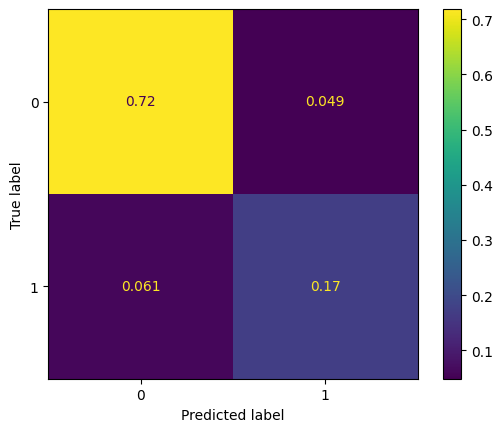

In [9]:
# Calculate confusion matrix
cm = confusion_matrix(labels_test, predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))
print(normalized_cm)
print()

# Plot the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test, normalize = 'all')

## XGBoost: k-fold cross-validation

In [10]:
# Cross validate the model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)
results = cross_validate(model, features_train, labels_train, cv = kfold, return_train_score = True)

In [11]:
# Fit for real on all training data
model.fit(features_train, labels_train)

# Evaluate on test data
y_pred = model.predict(features_test)
accuracy = accuracy_score(labels_test, predictions)

In [12]:
print('10-fold CV accuracy: %.2f%% (%.3f%%)' % (results['test_score'].mean() * 100, results['test_score'].std() * 100))
print('Hold out test set accuracy: %.2f%%' % (accuracy * 100.0))

10-fold CV accuracy: 88.98% (0.371%)
Hold out test set accuracy: 89.06%


## XGBoost hyperparameter tuning

In [26]:
def hyperopt_cv(
      params: dict = None, 
      random_state: int = 42, 
      kfolds: int = 10,
      fold_split: float = 0.5,
      features: np.ndarray = None, 
      labels: np.ndarray = None
) -> float:
   
   '''Cross validate an XGBoost classifier with a set of hyperparameters, returns mean CV core'''
    
   # Get the a set of variable parameters from params
   params = {
      'eta': params['eta'],
      # 'gamma': params['gamma'],
      'max_depth': int(params['max_depth']),
      # 'min_child_weight': params['min_child_weight'],
      # 'max_delta_step': int(params['max_delta_step']),
      # 'subsample': int(params['subsample']),
      # 'reg_alpha' : params['reg_alpha'],
      # 'reg_lambda' : params['reg_lambda'],
      'n_estimators': int(params['n_estimators'])
   }

   # Create a new XGB model using the values from params
   model = xgboost.XGBClassifier(device = 'cuda', random_state = random_state, **params)

   # Get number of examples in dataset
   n = labels.shape[0]

   # Set score to zero at start
   score = 0

   # Run k-fold with random samples
   for k in range(kfolds):
      
      # Pick random indicies without replacement for data to include in validation set
      validation_indicies = np.random.choice(range(n), size = (int(n*fold_split),), replace = False)    
      validation_mask = np.zeros(n, dtype = bool)
      validation_mask[validation_indicies] = True
      training_mask = ~validation_mask

      labels_train = labels[training_mask]
      features_train = features[training_mask]
      labels_validation = labels[validation_mask]
      features_validation = features[validation_mask]

      # Move data to GPU
      gpu_features_train = cp.array(features_train)
      gpu_labels_train = cp.array(labels_train)
      gpu_features_validation = cp.array(features_validation)
   
      # Fit the model
      model.fit(gpu_features_train, gpu_labels_train)

      # Make predictions for validation data
      labels_predicted = model.predict(gpu_features_validation)

      # Evaluate predictions, summing score across the folds
      score += accuracy_score(labels_validation, labels_predicted)

   # Return negated mean score for minimization
   return -score / kfolds

In [28]:
%%time

# How many iterations to run
n_iter = 50

# Fix random state
random_state = 42

# Parameter optimization space
space = {
       'eta': hp.uniform('eta', 0.001, 1.0),
       # 'gamma': hp.quniform('gamma', 0, 10, 1),
       'max_depth': hp.quniform('max_depth', 1, 100, 1),
       # 'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
       # 'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
       # 'subsample': hp.uniform('subsample', 0, 1),
       # 'reg_alpha': hp.quniform('reg_alpha', 0, 10, 1),
       # 'reg_lambda': hp.uniform('reg_lambda', 0, 10),
       'n_estimators': hp.quniform('n_estimators', 1, 1000, 1)
}

# Sete up trial logging
trials = Trials()

best = fmin(
       fn = partial(
              hyperopt_cv, 
              features = features_train.to_numpy(), 
              labels = labels_train
       ),
       space = space,           # Parameter: value dictionary
       algo = tpe.suggest,      # Optimization algorithm, hyperotp will select its parameters automatically
       max_evals = n_iter,      # Maximum number of iterations
       trials = trials,         # Logging
       rstate = np.random.default_rng(random_state)
)

print()

100%|██████████| 50/50 [28:47<00:00, 34.55s/trial, best loss: -0.8926583062393559]

CPU times: user 30min 12s, sys: 6.5 s, total: 30min 18s
Wall time: 28min 47s


In [29]:
# Fit on the complete training set with the winning parameters
model = xgboost.XGBClassifier(
    eta = best['eta'],
    # gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    # min_child_weight = best['min_child_weight'],
    # max_delta_step = int(best['max_delta_step']),
    # subsample = int(best['subsample']),
    # reg_alpha = best['reg_alpha'],
    # reg_lambda = best['reg_lambda'],
    n_estimators = int(best['n_estimators']),
    random_state = random_state
)

model.fit(features_train, labels_train)

# Run cross validation
results = cross_validate(model, features_train, labels_train, cv = kfold, return_train_score = True)

In [30]:
# Evaluate on test data
labels_predicted = model.predict(features_test)
accuracy = accuracy_score(labels_test, labels_predicted)

10-fold CV accuracy: 89.25% (0.350%)
Hold out test set accuracy: 89.41%

Confusion matrix:
[[19947  1280]
 [ 1651  4804]]

Normalized confusion matrix:
[[0.72057655 0.04623943]
 [0.05964164 0.17354237]]



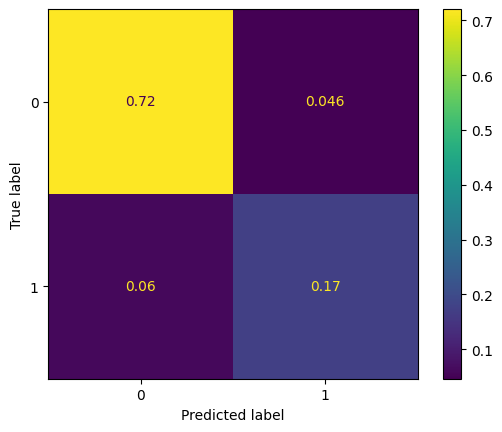

In [31]:
print('10-fold CV accuracy: %.2f%% (%.3f%%)' % (results['test_score'].mean() * 100, results['test_score'].std() * 100))
print('Hold out test set accuracy: %.2f%%' % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(labels_test, labels_predicted)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))
print(normalized_cm)
print()

# Plot the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test, normalize = 'all')

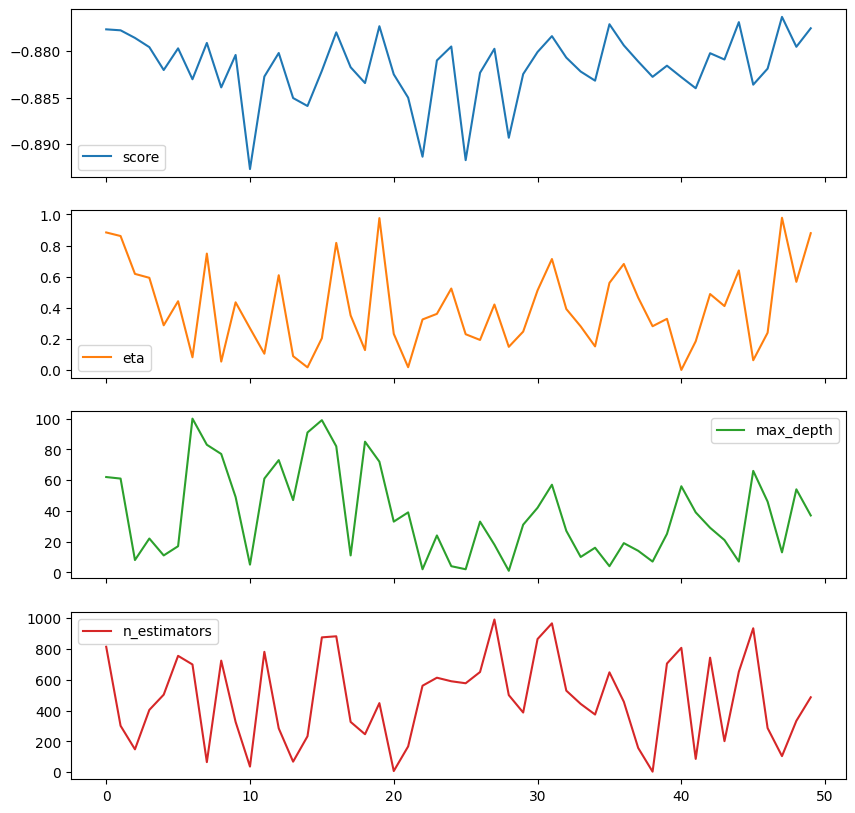

In [32]:
tpe_results = np.array([[
    x['result']['loss'],
    x['misc']['vals']['eta'][0],
    # x['misc']['vals']['gamma'][0],
    x['misc']['vals']['max_depth'][0],
    # x['misc']['vals']['min_child_weight'][0],
    # x['misc']['vals']['max_delta_step'][0],
    # x['misc']['vals']['subsample'][0],
    # x['misc']['vals']['reg_alpha'][0],
    # x['misc']['vals']['reg_lambda'][0],
    x['misc']['vals']['n_estimators'][0],

] for x in trials.trials])

tpe_results_df = pd.DataFrame(
    tpe_results, 
    columns = [
        'score', 
        'eta',
        # 'gamma',
        'max_depth',
        # 'min_child_weight',
        # 'max_delta_step',
        # 'subsample',
        # 'reg_alpha',
        # 'reg_lambda',
        'n_estimators'
    ]
)

optimzation_plot = tpe_results_df.plot(subplots = True, figsize = (10, 10))